In [1]:
from preproccessing import loadStooqData
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pyesg
import seaborn as sns
import matplotlib.pyplot as plt

In [384]:
data = loadStooqData('cpimpl.m','1990-01-01','m')

In [385]:
def ornstein_uhlenbeck_params(series,period):
    lagged = series.shift(1).dropna()
    series = series.iloc[1:]
    lagged = sm.add_constant(lagged,prepend=False)
    model = sm.OLS(series['Zamkniecie'],lagged[['Zamkniecie','const']])
    res = model.fit()
    b = res.params['Zamkniecie']
    a = res.params['const']
    k = (1 -b)/(1/period)
    u = a/k
    resid = res.resid
    sig = np.sqrt(np.mean(resid**2))
    sig = np.round(sig,4)

    return (u,sig,k)


,Zamkniecie
count,245.000000
mean,0.002727
std,0.004932
min,-0.005013
25%,0.000000
50%,0.001998
75%,0.004988
max,0.032467


<AxesSubplot:xlabel='Data', ylabel='Zamkniecie'>

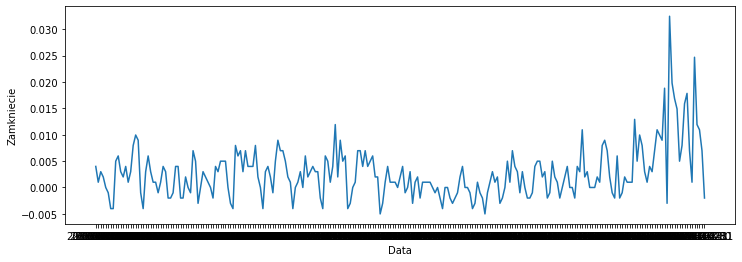

In [493]:
cpi = data['2003-01-01':'2023-12-31'] / 100
cpi = np.log(cpi+1)
cpi = cpi.reset_index()
display(cpi.describe())
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=cpi,x='Data',y='Zamkniecie', ax=ax)


<AxesSubplot:xlabel='Zamkniecie', ylabel='Count'>

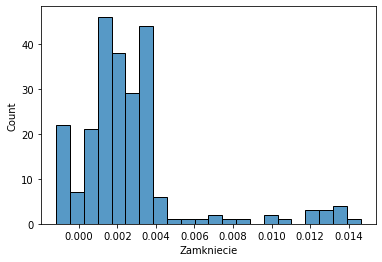

In [494]:
sns.histplot(data=cpi['Zamkniecie'].rolling(12).mean())

In [495]:
u,sig,k = ornstein_uhlenbeck_params(cpi,1)
print(u)
print(sig)
print(k)

0.002700159826935435
0.0044
0.5320401637725338


In [496]:
#moje param mu - 2,5%, sig, 1,5%, k- 0.k
param_mu = u
param_sig = sig
param_k = k
simulator = pyesg.OrnsteinUhlenbeckProcess(mu=param_mu,sigma=param_sig,theta=param_k)

In [497]:
length = 240
h=1
scenarios = simulator.scenarios(0,h,1000,length*h)

In [498]:
perc = np.percentile(scenarios,[1,5,25,50,75,95,99],axis=0)

In [499]:
def fanchart(hist,percentiles):
    x = np.linspace(0,percentiles.shape[1],percentiles.shape[1])
    fig,ax = plt.subplots(figsize=(12,6))
    ax.fill_between(x=x,y1=percentiles[0],y2=percentiles[6], color='blue', alpha=0.1)
    ax.fill_between(x=x,y1=percentiles[1],y2=percentiles[5], color='blue', alpha=0.2)
    ax.fill_between(x=x,y1=percentiles[2],y2=percentiles[4], color='blue', alpha=0.3)
    ax.plot(percentiles[3],color='blue')

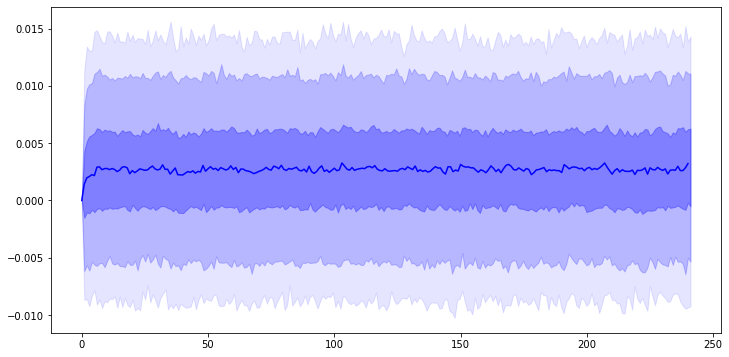

In [500]:
fanchart(cpi,perc)

In [501]:
def percentile_summary(perc,h):
    perc_dict = {'perc': ['1','5','25','50','75','95','99'],
                 '1': perc[:,1*h],
                 '2': perc[:,2*h],
                 '3': perc[:,3*h],
                 '5': perc[:,5*h],
                 '10': perc[:,10*h],
                 '20': perc[:,20*h],
                 '60': perc[:,60*h],
                 '120': perc[:,120*h]
                 #'2': perc[:,24],
                 #'3': perc[:,36],
                 #'5': perc[:,60],
                 #'10': perc[:,120],
                 #'15': perc[:,180]
                 }
    
    perc_summary = pd.DataFrame(perc_dict)
    perc_summary.set_index('perc', inplace=True)
    return perc_summary
percentile_summary(perc,h)

,1,2,3,5,10,20,60,120
perc,,,,,,,,
1,-0.008663,-0.008609,-0.009227,-0.007839,-0.008880,-0.008652,-0.008146,-0.009581
5,-0.006149,-0.005648,-0.006121,-0.005604,-0.005270,-0.005616,-0.005189,-0.005418
25,-0.001513,-0.001041,-0.001115,-0.001020,-0.000738,-0.000378,-0.000652,-0.000564
50,0.001437,0.001976,0.002092,0.002176,0.002792,0.002604,0.002709,0.002773
75,0.004315,0.005174,0.005597,0.005889,0.006082,0.005777,0.006323,0.006073
95,0.008355,0.009758,0.010141,0.011064,0.010816,0.010742,0.010983,0.010953
99,0.011384,0.013431,0.013049,0.014724,0.014729,0.014465,0.014483,0.014291


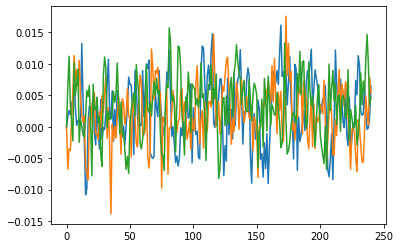

In [502]:
fig, ax = plt.subplots()
for i in np.random.randint(0,600,3):
    sns.lineplot(data=scenarios[i], ax=ax)



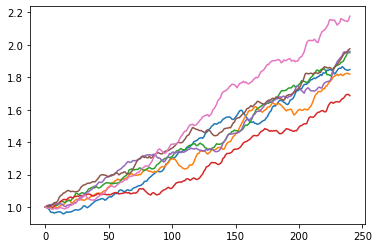

In [508]:
s_cum_prod = np.cumprod(np.exp(scenarios),1)
fig, ax = plt.subplots()
for i in np.random.randint(0,600,7):
    sns.lineplot(data=s_cum_prod[i], ax=ax)

In [509]:
year_cum = s_cum_prod[:,::12]

<AxesSubplot:xlabel='Zamkniecie', ylabel='Count'>

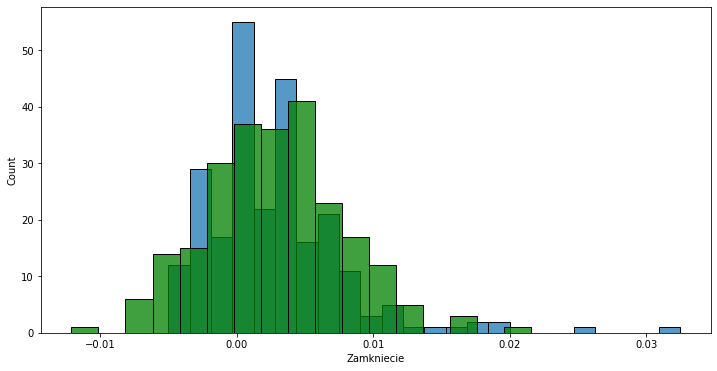

In [505]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(cpi['Zamkniecie'], ax=ax)
sns.histplot(scenarios[100],ax=ax,color='green')

In [506]:
means = scenarios.mean(1)

p = [1,5,25,50,75,95,99]
scenarios_perc = np.percentile(means,p)

for i in range(len(p)):
    print(str(np.round(p[i],4))+': '+str(np.round(scenarios_perc[i]*12,4)))


1: 0.0174
5: 0.0216
25: 0.0278
50: 0.0321
75: 0.0363
95: 0.0425
99: 0.0468


In [507]:
#np.savetxt('inlfation_scenarios_23.09.23.csv',scenarios,comments='u=0.02,sig=0.014,k=0.64')